In [6]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 11.7 MB 14.7 MB/s eta 0:00:01


In [11]:
!conda install -c rdkit rdkit -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |   py38h2b96118_5         369 KB  conda-forge
    boost-cpp-1.74.0           |       h312852a_4        16.3 MB  conda-forge
    brotli-1.0.9               |       h7f98852_6          18 KB  conda-forge
    brotli-bin-1.0.9           |       h7f98852_6          19 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    cairo-1.16.0               |    h6cf1ce9_1008         1.5 MB  conda-forge
    certifi-2021.10.8          |   py38h578d9bd_1         145 KB  conda-forge
    conda-4.11.0               |   py38h578d9bd_0        16.9 MB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    fontconfig-2.13.96         |

In [15]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.5 MB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 51.6 MB/s eta 0:00:01


In [2]:
# libraries for handling and visualization of data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# R & D imports for chemoinformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# torch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import lr_scheduler

# utilities
from collections import defaultdict
# import wandb
import time
import copy
from tqdm import tqdm
# from Bio.PDB import PDBParser
# from Bio.PDB import parse_pdb_header
# import xpdb  # this is the module described below
# from Bio import SeqIO
# import nglview
import gc

# optimizer AdamW by HuggingFace
from transformers import AdamW

In [28]:
train_csv = pd.read_csv('train.csv', index_col=0)

In [29]:
test_csv = pd.read_csv('test.csv')

In [30]:
test_data = test_csv

In [31]:
train_csv.columns

Index(['Smiles', 'Active'], dtype='object')

## Generating vectors from SMILES strings

In [32]:
PandasTools.AddMoleculeColumnToFrame(train_csv, 'Smiles', 'Molecule')

In [33]:
PandasTools.AddMoleculeColumnToFrame(test_data, 'Smiles', 'Molecule')

In [11]:
from molvecgen.vectorizers import SmilesVectorizer

In [12]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)

In [15]:
smivec.fit(train_csv.Molecule.values, )

In [17]:
# wrapping a SMILES vectorizer in a dataset
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        mols = self.molecules[idx]
        # The vectorizer was written to work with batches, 
        # but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        sample = torch.Tensor(sample).to(torch.float32)
        label = torch.Tensor([label]).to(torch.float32)
        return sample, label

## Automatical generation of molecular descriptors (over 100)

### Defining a class for automatic mol descriptor extraction

In [34]:
class RDKit_2D:
    def __init__(self, smiles, active):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles
        self.active = active
        
    def compute_2Drdkit(self, name):
        rdkit_2d_desc = []
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        header = calc.GetDescriptorNames()
        for i in range(len(self.mols)):
            ds = calc.CalcDescriptors(self.mols[i])
            rdkit_2d_desc.append(ds)
        df = pd.DataFrame(rdkit_2d_desc,columns=header)
        df.insert(loc=0, column='Smiles', value=self.smiles)
        df.insert(loc=1, column='Active', value=self.active)
        df.to_csv(name+'_RDKit_2D.csv', index=False)

In [39]:
class RDKit_2D_test:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles
        # self.active = active
        
    def compute_2Drdkit(self, name):
        rdkit_2d_desc = []
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        header = calc.GetDescriptorNames()
        for i in range(len(self.mols)):
            ds = calc.CalcDescriptors(self.mols[i])
            rdkit_2d_desc.append(ds)
        df = pd.DataFrame(rdkit_2d_desc,columns=header)
        df.insert(loc=0, column='Smiles', value=self.smiles)
        # df.insert(loc=1, column='Active', value=self.active)
        df.to_csv(name+'_RDKit_2D.csv', index=False)

### Generating and saving extended pandas dataframes with over 100 molecular descriptors

In [36]:
train_inst_rdkit = RDKit_2D(train_csv['Smiles'], train_csv['Active'])

In [37]:
train_inst_rdkit.compute_2Drdkit("train_superXxxxx")

In [40]:
test_inst_rdkit = RDKit_2D_test(test_csv['Smiles'])

In [41]:
test_inst_rdkit.compute_2Drdkit("test_superXxxxx")

## Reloading test and train dataframes from CSVs with extended features

In [44]:
# del train_csv, test_csv
train_csv = pd.read_csv('train_superXxxxx_RDKit_2D.csv')
test_csv = pd.read_csv('test_superXxxxx_RDKit_2D.csv')
# alias for test
test_data = test_csv

## Generating folds for cat boost and CV

In [46]:
def create_folds(data, num_splits=3):
    if num_splits > 1:
        data.loc[:,'kfold'] = -1
        X = data['Smiles']
        y = data['Active']
        mskf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

        for fold, (trn_, val_) in enumerate(mskf.split(X,y)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
    return data

df = create_folds(train_csv, num_splits = config["n_fold"])

# Catboost model

In [47]:
from sklearn.model_selection import KFold # k-фолдная валидация
from catboost import CatBoostClassifier

In [49]:
# train => full_data
full_data = df
# test => test_data
# test_data = pd.read_csv('test.csv')

full_data = full_data.rename(columns={'Active':'target'})

# Добавь сюда нужные фичи => 
filtered_features = list(calc.GetDescriptorNames())

In [165]:
fd_copy = pd.DataFrame.copy(full_data)

X = fd_copy[filtered_features + ['kfold']]
y = full_data[['target', 'kfold']]

In [51]:
n_splits = 3

clfs = []

fd_copy = pd.DataFrame.copy(full_data)
for feature in filtered_features:
    fd_copy[feature] = full_data[feature].apply(lambda x: str(x))
test_copy = pd.DataFrame.copy(test_data)
for feature in filtered_features:
    test_copy[feature] = test_data[feature].apply(lambda x: str(x))
X = fd_copy[filtered_features + ['kfold']]
y = full_data[['target', 'kfold']]

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

for kfold in range(n_splits):
    
    X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
    y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)
    print(X_train.shape)
    clf = CatBoostClassifier(iterations = 10000,
                          loss_function = 'Logloss', #eval_metric = 'F1', #'AUC:hints=skip_train~false',
                          cat_features = filtered_features,
                          random_seed=42,                          
                          # 'learning_rate': 0.05953207713558619,
                          # colsample_bylevel =  0.09874152157026818,
                          # subsample = 0.9563761143682146,
                          # l2_leaf_reg = 9.178962968420354,
                          # 'random_strength': 2.4354466502188408,
#                           min_data_in_leaf = 243,
#                           max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds=200 + kfold*10 )
    clfs.append(clf)

    clf.fit(X_train, y_train, eval_set=(X_test, y_test),
            verbose = 150, use_best_model = True, plot = False)
        
        
assert len(clfs) == N

# массив для записи финального результата
y_pred = np.zeros((test_data.shape[0],))
scores = []
for clf in clfs:
    y_pred += clf.predict_proba(test_copy[filtered_features])[:,1]
    scores.append(clf.best_score_['validation']['Logloss'])
y_pred /= N
print(y_pred)
print('mean Logloss', np.mean(scores))

(3704, 208)
Learning rate set to 0.016083
0:	learn: 0.6688602	test: 0.6685825	best: 0.6685825 (0)	total: 442ms	remaining: 1h 13m 36s
150:	learn: 0.1413024	test: 0.1485402	best: 0.1485402 (150)	total: 20.6s	remaining: 22m 26s
300:	learn: 0.1260730	test: 0.1416447	best: 0.1416347 (299)	total: 49.1s	remaining: 26m 22s
450:	learn: 0.1176747	test: 0.1376720	best: 0.1376720 (450)	total: 1m 14s	remaining: 26m 13s
600:	learn: 0.1110409	test: 0.1360934	best: 0.1360934 (600)	total: 1m 46s	remaining: 27m 37s
750:	learn: 0.1040751	test: 0.1347155	best: 0.1347155 (750)	total: 2m 19s	remaining: 28m 44s
900:	learn: 0.0982721	test: 0.1333647	best: 0.1333647 (900)	total: 2m 53s	remaining: 29m 15s
1050:	learn: 0.0929418	test: 0.1326028	best: 0.1326015 (1047)	total: 3m 27s	remaining: 29m 30s
1200:	learn: 0.0882226	test: 0.1318778	best: 0.1318379 (1180)	total: 3m 59s	remaining: 29m 16s
1350:	learn: 0.0836378	test: 0.1316214	best: 0.1315888 (1339)	total: 4m 31s	remaining: 28m 56s
1500:	learn: 0.0797999	tes

In [52]:
# y_pred[y_pred >= 0.1] = True
y = y_pred > 0.1

In [53]:
for n, clf in enumerate(clfs):
    clf.save_model("catboost_model_{}_m".format(n))
# from_file = CatBoostClassifier()
# from_file.load_model("model")

## Make Submission

In [54]:
sample = pd.read_csv('Task/test.csv')
pred = y_pred
# pred = (pred > 0.35).astype(int)
res = np.argmax(pred, axis=1).astype(int)

assert pred.shape[0] == len(sample)
pred = pd.DataFrame(data={'target':res}, index=sample['Smiles'])

AxisError: axis 1 is out of bounds for array of dimension 1

In [55]:
sample['Active'] = y
sample[['Smiles', 'Active']].to_csv('submission_4.csv', index=False)
# sample[['review_id', 'target']].head(15)

# Feature Importance

In [173]:
import seaborn as sns

Всего признаков 12 Усреднее по 3-ти моделям: 
На график нанесено топ-70 признаков


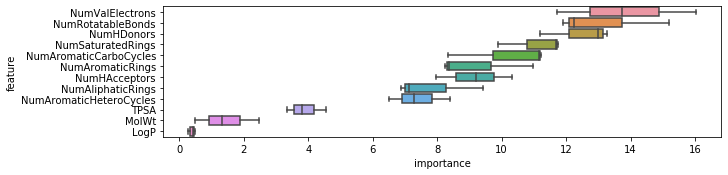

In [174]:
def plot_importance(data, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = data.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(full_data[filtered_features], clfs, 0.20, top_n=70)